This notebook is a tutorial for TF-Activity inference using SEACells. It includes gene trend computation, TF-target matrix construction, lasso regression and TF-Activity inference. In this tutorial, we will infer TF-activity in the context of erythropoiesis to identify driving TFs.

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import palantir
import warnings
from tqdm.auto import tqdm

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import SEACells

Setting up plotting aesthetics

In [5]:
sc.set_figure_params(scanpy=False, frameon=False, format='png', transparent=True)

In [6]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of multiome dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [7]:
#!mkdir data/
#!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad # RNA data
#!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data

In [8]:
rna_ad = sc.read('data/cd34_multiome_rna.h5ad')
atac_ad = sc.read('data/cd34_multiome_atac.h5ad')

In [9]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [10]:
atac_ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

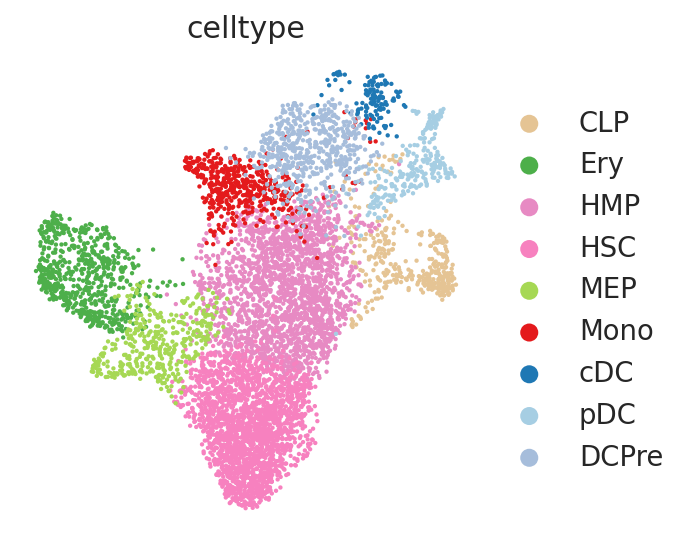

In [11]:
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon=False)

In [12]:
ct_colors = dict(zip(rna_ad.obs['celltype'].cat.categories, rna_ad.uns['celltype_colors']))

## gene-peak correlations
Gene-peak correlations will be used to inform gene selection and TF-target matrix computation.

Full gene-peak correlations results for this dataset are available as a pickle file at https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p This can be downloaded by using the following command:

In [13]:
#! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p -O data/cd34_multiome_gene_peak_cors.p 

In [14]:
gene_peak_cors = pd.read_pickle('data/cd34_multiome_gene_peak_cors.p')

## PWM

The Position Weight Matrix (PWM) contains information about TF binding specificities at different locations in the genome. A PWM is available for download at: https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/pwm_ad.h5ad using the following command:

In [15]:
#! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/pwm_ad.h5ad -O data/pwm_ad.h5ad 

In [16]:
pwm = sc.read('data/pwm_ad.h5ad')
pwm

AnnData object with n_obs × n_vars = 246113 × 729

In [17]:
# Filter PWM to TFs present in dataset
has_expr = [g in rna_ad.var_names for g in pwm.var_names]
frac = sum(has_expr) / len(has_expr)
print(f"{frac:.2%} ({sum(has_expr)}) TFs have expresssion")

pwm = pwm[:, has_expr]

41.29% (301) TFs have expresssion


# Compute pseudotime

For the TF-Activity inference, we will be predicting expression profiles based on gene expression trends along pseudotime. To achieve a cell ordering, we suggest using Palantir to compute pseudotime.

**NOTE:** Lasso regression can be run directly on expression if the user desires. If so, can skip pseudotime and gene trend computation sections. The user will need to comment out all references to pseudotime

In [18]:
# Making a copy of RNA AnnData for pseudotime computation and downstream differential expression analysis
rna_ad_norm = rna_ad.copy()
sc.pp.normalize_total(rna_ad_norm)
sc.pp.log1p(rna_ad_norm)

In [19]:
sc.pp.pca(rna_ad_norm, n_comps=30, use_highly_variable=True)

pca_projections = pd.DataFrame(rna_ad_norm.obsm['X_pca'], index=rna_ad_norm.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)

Determing nearest neighbor graph...


In [20]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)


In [21]:
terminal_states = pd.Series(['cDC', 'CLP', 'pDC', 'Mega', 'Ery', 'Mono'], 
                           index=['cd34_multiome_rep1#GCACATTAGTTGTCAA-1', 'cd34_multiome_rep2#AAACGTACACCTGCCT-1', 
                                  'cd34_multiome_rep2#ATTTAGCCAATATACC-1', 'cd34_multiome_rep2#GTACGTAGTTGTAAAC-1', 
                                  'cd34_multiome_rep2#CTTCGCGTCAGCATTA-1', 'cd34_multiome_rep2#TTTCCTGAGCTGTAAC-1'])

In [22]:
start_cell = 'cd34_multiome_rep2#TGTGGCGGTAGGATTT-1'

pr_res = palantir.core.run_palantir(ms_data, start_cell,
                                    terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.021364919344584146 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back t

Time for shortest paths: 0.19161167939503987 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/palantir/core.py:447: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ent = ent.append(pd.Series(0, index=terminal_states))
/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/palantir/core.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  branch_probs = branch_probs.append(bp.loc[:, branch_probs.columns])


In [23]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

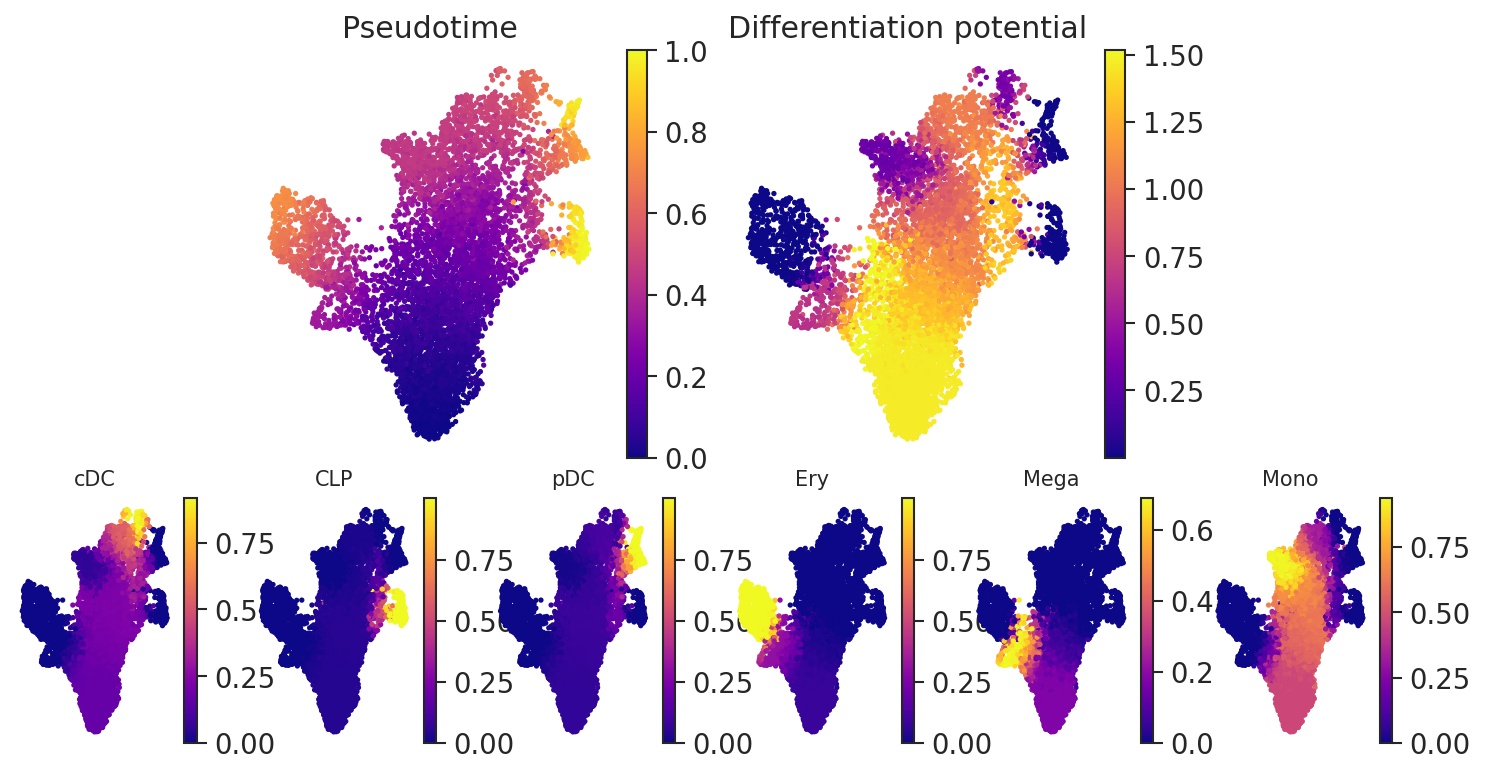

In [24]:
umap = pd.DataFrame(rna_ad.obsm['X_umap'], index=rna_ad.obs_names,columns=['x', 'y'])
palantir.plot.plot_palantir_results(pr_res, umap)

In [25]:
rna_ad.obs['pseudotime'] = pr_res.pseudotime[rna_ad.obs_names]

# summarize RNA
We need to summarize the RNA data by aggregating cells and summing up raw, unnormalized data. We will summarize based off of ATAC SEACell assignments.

In [26]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACells_label='SEACell')


Generating Metacell matrices...
 ATAC


  0%|          | 0/100 [00:00<?, ?it/s]

/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/SEACells-0.2.0-py3.8.egg/SEACells/genescores.py:48: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_meta_ad.obsm['X_svd'] = summ_svd.loc[atac_meta_ad.obs_names, :].values
/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/SEACells-0.2.0-py3.8.egg/SEACells/genescores.py:77: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  atac_ad.var['log_n_counts'] = np.ravel(np.log10(atac_ad.X.sum(axis=0)))


 RNA


/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/SEACells-0.2.0-py3.8.egg/SEACells/genescores.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_mod_ad.obs['temp'] = atac_mod_ad.obs[SEACells_label]


  0%|          | 0/100 [00:00<?, ?it/s]

/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/SEACells-0.2.0-py3.8.egg/SEACells/genescores.py:69: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  meta_ad.raw = meta_ad.copy()


In [27]:
rna_meta_ad

AnnData object with n_obs × n_vars = 99 × 12464
    obs: 'n_counts'
    uns: 'log1p'
    layers: 'raw'

## Summarize attributes

Attribute annotations for each SEACell can be aggregated from the single-cell RNA annotations. UMAP coordinates and pseuotime are averaged over cells belonging to a SEACell. Cell type assignments are determined by the most prevalent cell type amongst cells comprising a SEACell

In [28]:
rna_umap = pd.DataFrame(rna_ad.obsm['X_umap'], index=rna_ad.obs_names)
rna_meta_ad.obsm['X_umap'] = rna_umap.groupby(atac_ad.obs['SEACell']).mean().loc[rna_meta_ad.obs_names, :].values

In [29]:
# Aggregate pseudotime values
avg_pseudotime = rna_ad.obs['pseudotime'].groupby(atac_ad.obs['SEACell']).mean().loc[rna_meta_ad.obs_names].values

rna_meta_ad.obs['palantir_pseudotime'] = avg_pseudotime

In [30]:
# Identify most abundant cell type annotation for each SEACell
top_ct = rna_ad.obs['celltype'].groupby(atac_ad.obs['SEACell']).value_counts().groupby(level=0, group_keys=False).head(1)

rna_meta_ad.obs['celltype'] = top_ct[rna_meta_ad.obs_names].index.get_level_values(1)
rna_meta_ad.uns['celltype_colors'] = [ct_colors[ct] for ct in rna_meta_ad.obs['celltype'].cat.categories]

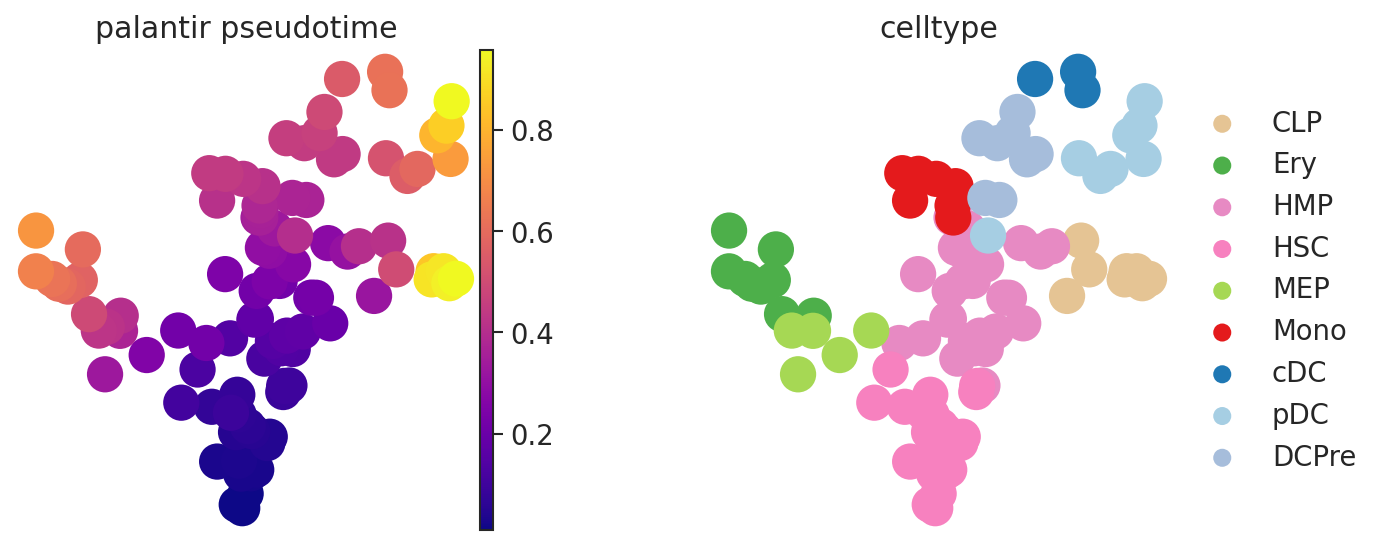

In [31]:
sc.pl.scatter(rna_meta_ad, basis='umap', color=['palantir_pseudotime', 'celltype'], color_map='plasma')

## Subset to Erythroid trajectory

To identify active TFs during erythropoiesis, we subset the metacell AnnData to include only cell types along the erythroid trajectory

In [32]:
ery_cts = ['HSC', 'Ery', 'MEP']

mc_sub = rna_meta_ad[rna_meta_ad.obs['celltype'].isin(ery_cts), :].copy()
mc_sub.uns['celltype_colors'] = list(mc_sub.uns['celltype_colors'])
cell_order = mc_sub.obs.sort_values('palantir_pseudotime').index
mc_expr = mc_sub.to_df()


# Gene selection

In order to focus our analysis, we will perform pairwise differential expression analysis to identify genes enriched in the erythroid trajectory over others.

Genes will be further subsetted based on adequate gene-peak correlations and high expression in the erythroid trajectory. These genes will be used downstream for gene-trend computation

## Differential gene expression

In [33]:
cts = rna_ad.obs['celltype'].unique()

In [34]:
ct_dict = SEACells.tfactivity.get_de_genes(rna_ad_norm,cts, 4 ,'celltype')

threshold: 4



  0%|          | 0/9 [00:00<?, ?it/s]

HMP
	num genes: 368
DCPre
	num genes: 415
HSC
	num genes: 605
Ery
	num genes: 530
MEP
	num genes: 286
cDC
	num genes: 546
CLP
	num genes: 296
Mono
	num genes: 248
pDC
	num genes: 529


In [35]:
de_genes = list(set([gene for ct in ery_cts for gene in ct_dict[ct]]))

## Subset genes

In [36]:
# count the number of significantly correlated peaks for each gene
gene_peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors,
                                                                 pval_cutoff=1e-1, cor_cutoff=0.2)

100%|███████████████████████| 12464/12464 [00:03<00:00, 3233.70it/s]


In [37]:
gene_set = SEACells.tfactivity.get_gene_set(rna_meta_ad, gene_peak_counts, de_genes, 
                                             'celltype',ery_cts, expr_thresh=2.0)

Number of genes...
   ...highly expressed in ['HSC', 'Ery', 'MEP']: 9000
   ...correlated 5+ peaks: 4299
   ...differentially expressed: 1077
...taking intersection...

TOTAL: 470


# TF-target matrix

The TF-target matrix will be the feature matrix for TF-activity inference. We first need to subset to genes with at least 5 significantly correlated peaks

In order to make the TF-target matrix, we need to assosicate each gene with TFs that bind to peaks the gene is correlated with.

**NOTE:** the `min_corr` and `min_peaks` parameters should match what was used above during gene selection.

In [38]:
gene_tf = SEACells.tfactivity.gene_tf_associations(gene_peak_cors, pwm, min_corr=0.2, min_peaks=5)

genes:   0%|          | 0/12464 [00:00<?, ?it/s]

4,299 genes and 434,765 gene-TF combinations with at least 5 peaks.


In [39]:
tf_target_mat = SEACells.tfactivity.compute_tf_target_mat(pwm, gene_peak_cors, gene_tf)

  0%|          | 0/4299 [00:00<?, ?it/s]

# Gene trend computation

To infer TF-activity, we will try to predict the expression profile of the our selected genes based off of the TF-target matrix. Here we compute gene expression trends along computed pseudotime to serve as input for the Lasso regression. 

In [40]:
pseudotime = mc_sub.obs.sort_values('palantir_pseudotime')['palantir_pseudotime']

In [41]:
pred_expr = pd.DataFrame(0.0, index=gene_set, columns=pseudotime.index.copy())
for gene in gene_set:
    y_pred, stds = palantir.presults.gam_fit_predict(pseudotime.values, mc_expr.loc[pseudotime.index, gene], 
                                                     n_splines=20, spline_order=3)
    pred_expr.loc[gene] = y_pred

In [42]:
mc_sub

AnnData object with n_obs × n_vars = 36 × 12464
    obs: 'n_counts', 'palantir_pseudotime', 'celltype'
    uns: 'log1p', 'celltype_colors'
    obsm: 'X_umap'
    layers: 'raw'

/home/cdien/.conda/envs/seacells_tfa/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


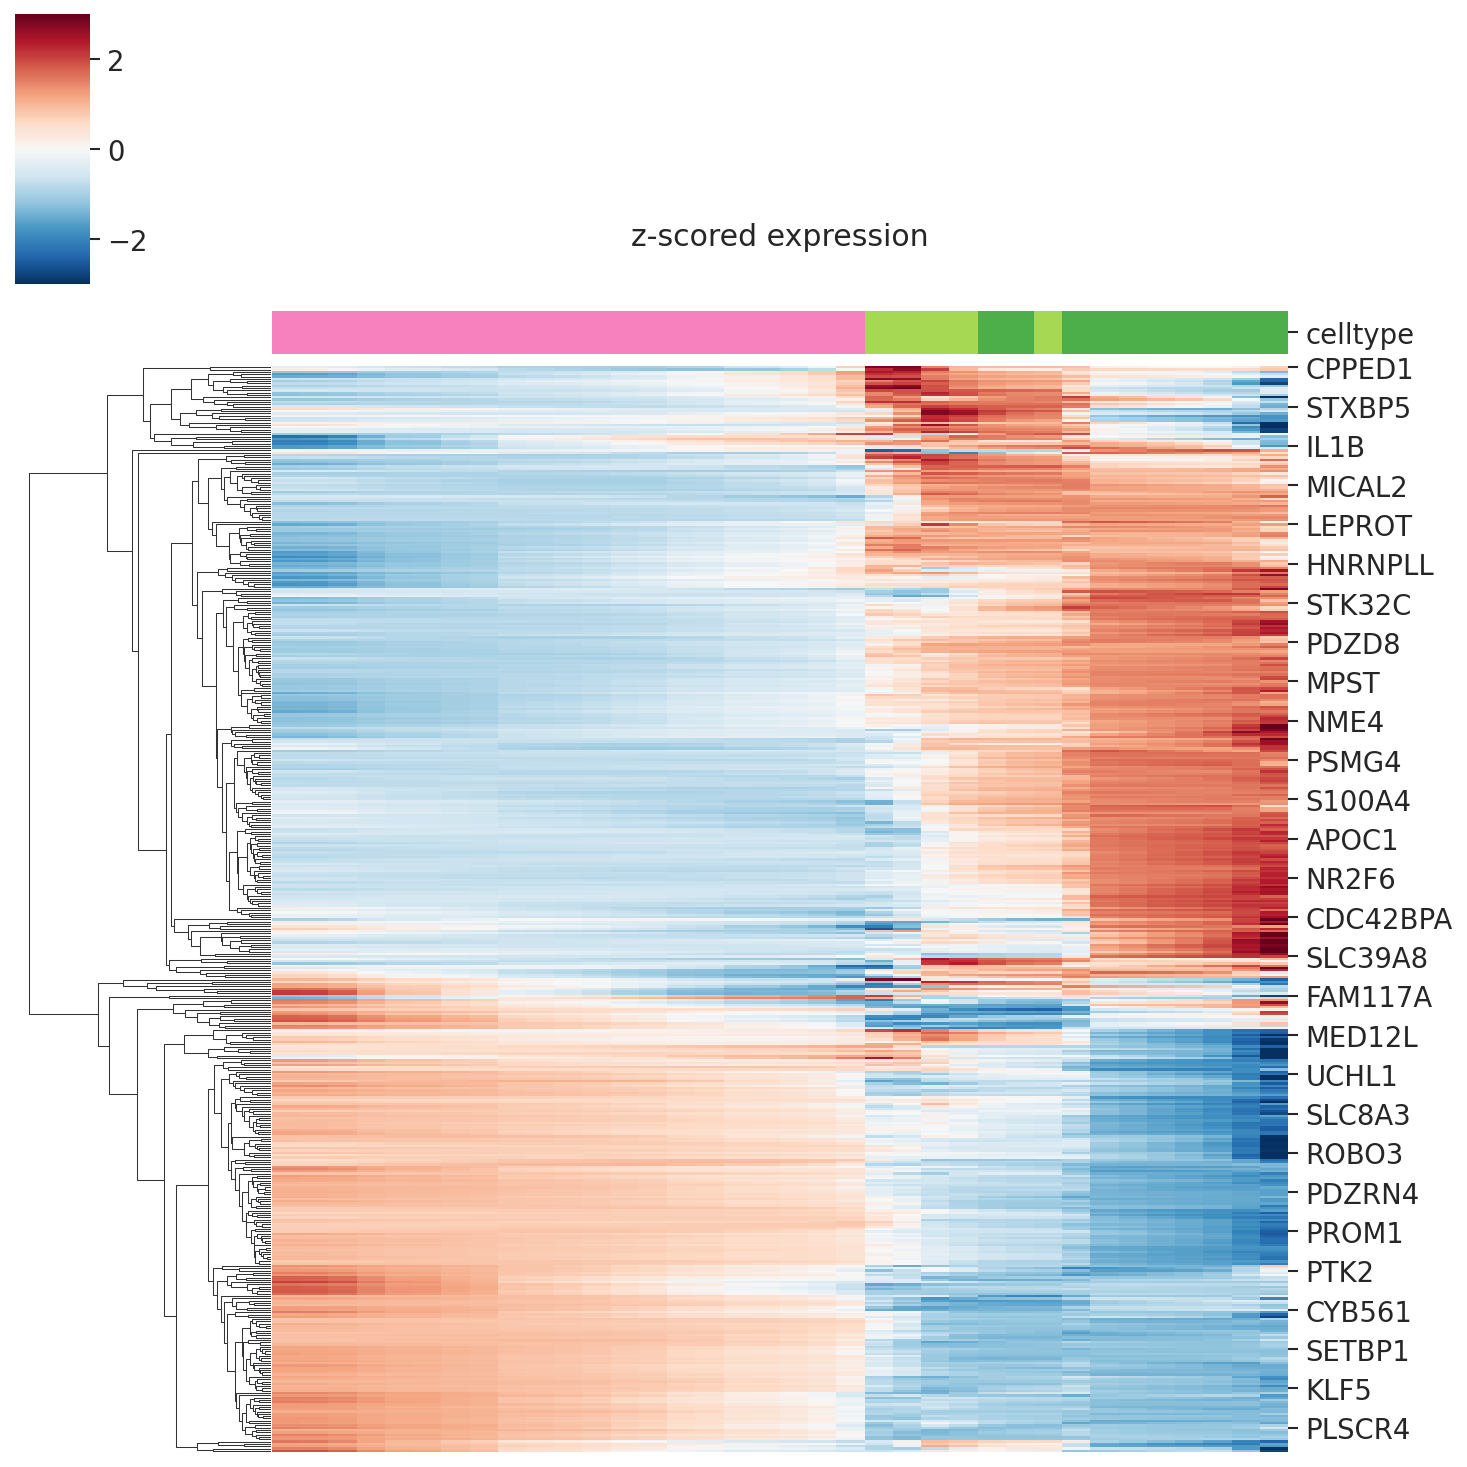

In [43]:
ery_zs = pd.DataFrame(sc.pp.scale(pred_expr.T.values, copy=True).T, columns=cell_order, index=gene_set)

col_colors = mc_sub.obs['celltype'].map(ct_colors)

g = sns.clustermap(ery_zs.loc[:,cell_order], cmap='RdBu_r', col_cluster=False, col_colors=col_colors, vmin=-3, vmax=3, xticklabels=False)
g.ax_heatmap.set_title('z-scored expression', y=1.1) 

plt.show()


The z-scored expression profile will be the target of the lasso regression.

# Lasso regression

We start by filtering TFs to include those enriched in the Erythroid trajectory

In [44]:
tfs = tf_target_mat.columns
tf_zs = pd.DataFrame(sc.pp.scale(rna_meta_ad.to_df()[tfs].values, copy=True),
                     index=rna_meta_ad.to_df().index, columns=tfs)

ct_zs = (tf_zs.groupby(rna_meta_ad.obs['celltype']).mean() > 0.9)
tf_filt = tfs[ct_zs.loc[ery_cts].sum() > 0]

print(f'Number of TFs: {len(tf_filt)}')

Number of TFs: 55


Fit the Lasso regression on a metacell-by-metacell basis.

In [45]:
np.random.seed(1)
mc_res = SEACells.tfactivity.fit_lasso_model(tf_target_mat, ery_zs,
                                              gene_set=gene_set, tf_set=tf_filt, cells=mc_sub.obs_names)

  0%|          | 0/36 [00:00<?, ?it/s]

# TF-activity Inference

We are interested in identifying TFs that are active during erythropoiesis. We can use the feature coefficients as a coarse filter for unimportant features. 

We subset to TFs that have a non-zero coefficient in at least 1 cell:

In [46]:
mc_valid_tfs = SEACells.tfactivity.non_zero_tfs(mc_sub.obs_names, mc_res, 1)

  0%|          | 0/36 [00:00<?, ?it/s]

Number of Qualifying TFs: 53



Next, we compute the importance of each TF by calculating the change in the RMSE after reducing individual TF's coefficients to zero. This value represents 

In [47]:
tf_activity = SEACells.tfactivity.compute_tf_activity(mc_sub, mc_res, mc_valid_tfs, cell_order)

  0%|          | 0/36 [00:00<?, ?it/s]

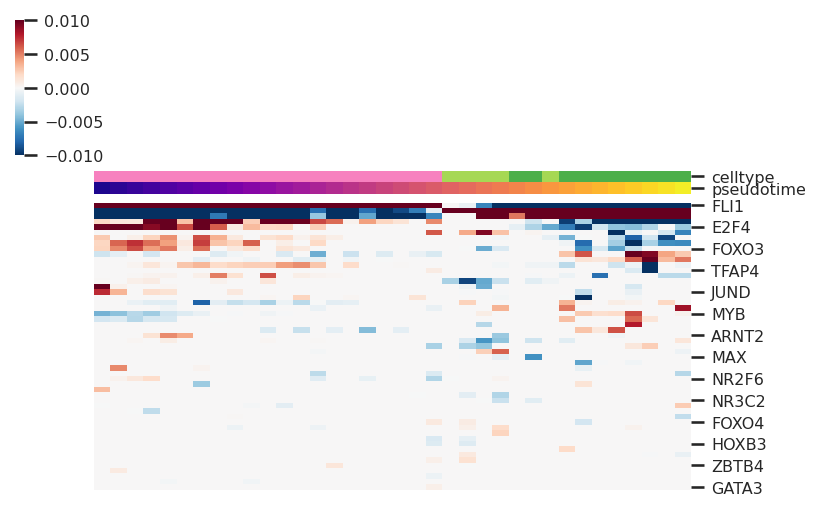

In [48]:
# Visualize TF-Activity for qualifying TFs
ct_col_colors = mc_sub.obs['celltype'].map(ct_colors)

pal = sns.palettes.color_palette('plasma', len(mc_sub.obs_names))
lut = dict(zip(np.sort(mc_sub.obs['palantir_pseudotime'].unique()), pal))
pt_col_colors = mc_sub.obs['palantir_pseudotime'].map(lut)

col_colors = pd.DataFrame({'celltype':ct_col_colors,
                           'pseudotime':pt_col_colors})
sns.set(font_scale=0.7)
g = sns.clustermap(tf_activity, col_cluster=False, row_cluster=True, cmap='RdBu_r', vmin=-0.01, vmax=0.01,
                   col_colors=col_colors,  xticklabels=False, figsize=(6,3), cbar_pos=(0.1, 0.8, 0.01, 0.3))
g.ax_row_dendrogram.set_visible(False)


To identify the top 5 active TFs, we rank by total TF activity and visualize TF-activity below

In [49]:
top_tfs = np.abs(tf_activity).sum(axis=1).sort_values(ascending=False).index[:5]
top_tfs.values

array(['FLI1', 'GATA1', 'GATA2', 'STAT5B', 'E2F4'], dtype=object)

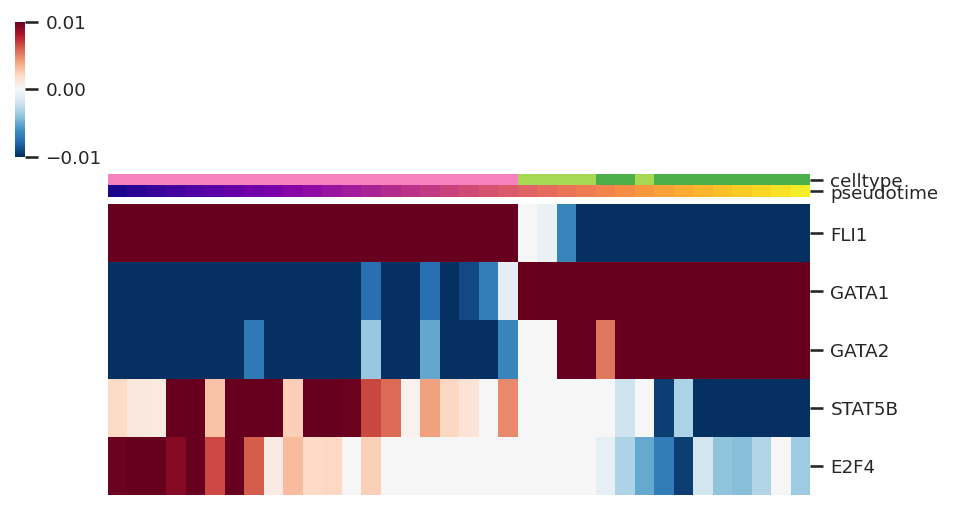

In [50]:
top_tf_activity = tf_activity.loc[top_tfs]

ct_col_colors = mc_sub.obs['celltype'].map(ct_colors)

pal = sns.palettes.color_palette('plasma', len(mc_sub.obs_names))
lut = dict(zip(np.sort(mc_sub.obs['palantir_pseudotime'].unique()), pal))
pt_col_colors = mc_sub.obs['palantir_pseudotime'].map(lut)

col_colors = pd.DataFrame({'celltype':ct_col_colors,
                           'pseudotime':pt_col_colors})
sns.set(font_scale=0.8)
g = sns.clustermap(top_tf_activity, col_cluster=False, row_cluster=True, cmap='RdBu_r', vmin=-0.01, vmax=0.01,
                   col_colors=col_colors,  xticklabels=False, figsize=(7,3), cbar_pos=(0.1, 0.8, 0.01, 0.3))
g.ax_row_dendrogram.set_visible(False)
